In this notebook you will see how to set simple constraints on BN learning and how sometimes Gobnilp's parameters need to be changed from their default values to make this possible. We start by learning a BN from `discrete.dat` with no parent set limit.

**********
BN has score -24028.09477835351
**********
A<- -5502.137377150637
B<-A -3688.9395212202216
C<- -3501.5105385969146
D<-A,C -3555.0144442365527
E<-B,F -4310.3049564706525
F<- -3470.18794067853
**********
bnlearn modelstring = 
[A][B|A][C][D|C:A][E|F:B][F]
**********
CPDAG:
Vertices: A,B,C,D,E,F
A-B
A->D
B->E
C->D
F->E



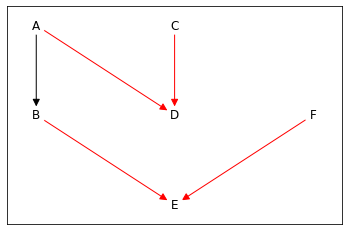

In [2]:
from gobnilp import Gobnilp
m = Gobnilp()
m.use_discrete_data('discrete.dat',palim=None)

Now, suppose, that for some reason we decided that we were only interested in BNs where there was an arrow between C and F - in either direction, i.e. there was an undirected edge between these two nodes in the undirected version of the BN. In Gobnilp, these undirected edges are called `adjacencies` and there are binary variables in the MIP model stored in an Gobnilp attribute called `adjacency` which is a dictionary. Let's have a look at it:

In [2]:
for pair, mipvar in m.adjacency.items():
    print('adjacency is {0}, MIP variable is {1}'.format(pair,mipvar))

adjacency is frozenset({'B', 'A'}), MIP variable is <gurobi.Var A-B (value 1.0)>
adjacency is frozenset({'C', 'A'}), MIP variable is <gurobi.Var A-C (value 0.0)>
adjacency is frozenset({'D', 'A'}), MIP variable is <gurobi.Var A-D (value 1.0)>
adjacency is frozenset({'E', 'A'}), MIP variable is <gurobi.Var A-E (value 0.0)>
adjacency is frozenset({'F', 'A'}), MIP variable is <gurobi.Var A-F (value 0.0)>
adjacency is frozenset({'B', 'C'}), MIP variable is <gurobi.Var B-C (value 0.0)>
adjacency is frozenset({'D', 'B'}), MIP variable is <gurobi.Var B-D (value 0.0)>
adjacency is frozenset({'B', 'E'}), MIP variable is <gurobi.Var B-E (value 1.0)>
adjacency is frozenset({'F', 'B'}), MIP variable is <gurobi.Var B-F (value 0.0)>
adjacency is frozenset({'D', 'C'}), MIP variable is <gurobi.Var C-D (value 1.0)>
adjacency is frozenset({'D', 'E'}), MIP variable is <gurobi.Var D-E (value 0.0)>
adjacency is frozenset({'F', 'E'}), MIP variable is <gurobi.Var E-F (value 1.0)>


So the keys of the dictionary are Python frozensets and the values they map to are Gurobi MIP variables. Each of these MIP variables is binary and indicates whether the adjacency is present. Note that the values of the MIP variables correspond to the learned BN, since we (or rather Gurobi) has already solved the MIP problem.

There is however no adjacency variable for C and F. This is because when we were computing local scores from the data, Gobnilp does (by default) 'pruning' - It does not include any parent sets which could not possibly be in an optimal network **assuming no constraints other than acyclicity**. As it happens this led to no parent set for C including F and no parent set for F including C. As a result with these parent sets there can be no adjacency between C and F and so Gobnilp does not create a corresponding adjacency variable.

We can have a look at the parent sets which have been created for, say, variables C and F by inspecting the `local_scores` attribute which is a dictionary.

In [3]:
print(m.local_scores['C'])
print(m.local_scores['F'])

{frozenset(): -3501.5105385969146, frozenset({'D'}): -3490.1353818719726, frozenset({'D', 'A'}): -2703.3502358326805, frozenset({'D', 'B'}): -3348.715894737994}
{frozenset(): -3470.18794067853, frozenset({'E'}): -3026.9672848237205, frozenset({'E', 'A'}): -3026.4417706210625, frozenset({'B', 'E'}): -2933.754847081549}


So we have a mapping from parent sets (as frozensets) to the corresponding local score. There is also a binary MIP variable for each child + parent set combination. child+parents is called a 'family' in Gobnilp and the MIP variables are found in the `family` attribute:

In [4]:
print(m.family['C'])
print(m.family['F'])

{frozenset(): <gurobi.Var C<-{} (value 1.0)>, frozenset({'D'}): <gurobi.Var C<-{D} (value 0.0)>, frozenset({'D', 'A'}): <gurobi.Var C<-{A,D} (value 0.0)>, frozenset({'D', 'B'}): <gurobi.Var C<-{B,D} (value 0.0)>}
{frozenset(): <gurobi.Var F<-{} (value 1.0)>, frozenset({'E'}): <gurobi.Var F<-{E} (value 0.0)>, frozenset({'E', 'A'}): <gurobi.Var F<-{A,E} (value 0.0)>, frozenset({'B', 'E'}): <gurobi.Var F<-{B,E} (value 0.0)>}


To find the optimal BN **subject to there being an adjacency between C and F** we need to sure that we do not 'prune away' parent sets needed for this BN. The safe way of acheiving this is to just turn pruning off entirely:

**********
BN has score -24028.09477835351
**********
A<- -5502.137377150637
B<-A -3688.9395212202216
C<- -3501.5105385969146
D<-A,C -3555.0144442365527
E<-B,F -4310.3049564706525
F<- -3470.18794067853
**********
[A][B|A][C][D|C:A][E|F:B][F]
CPDAG:
Vertices: ['A', 'B', 'C', 'D', 'E', 'F']
A-B
A->D
B->E
C->D
F->E



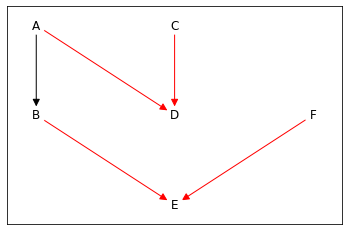

In [5]:
m = Gobnilp()
m.use_discrete_data('discrete.dat',palim=None,pruning=False)

We get exactly the same BN since we have yet to add any new constraints. But now at least we have the needed MIP variable available:

In [6]:
adj_cf = m.adjacency[frozenset(['C','F'])]
print(adj_cf)

<gurobi.Var C-F (value 0.0)>


Although `adj_cf` has value 0 in the learned BN, it was not *compelled* to take that value by some constraint. It has the normal bounds for a binary variable: 0 and 1. We can see this by looking at its `lb` (lower bound) and `ub` (upper bound) values. Note that these are Gurobi MIP variable attributes and are not part of gobnilp. 

In [7]:
adj_cf.lb, adj_cf.ub

(0.0, 1.0)

To fix `adj_cf` to 1 we just alter its lower bound:

In [8]:
adj_cf.lb = 1

Now we need to re-learn with this new constraint. To do this we call the Gurobi method `reset` - to return the MIP model to an unsolved state and then the method `learn`. Since we already have created MIP variables and constraints (by the call to `use_discrete_data`) we have to set `make_basic_model` to `False` otherwise Gobnilp will throw an error complaining that we are creating MIP variables when they already exist.

**********
BN has score -24036.17071086453
**********
A<- -5502.137377150637
B<-A -3688.9395212202216
C<- -3501.5105385969146
D<-A,C -3555.0144442365527
E<-B,F -4310.3049564706525
F<-C -3478.263873189553
**********
[A][B|A][C][D|C:A][E|F:B][F|C]
CPDAG:
Vertices: ['A', 'B', 'C', 'D', 'E', 'F']
A-B
A->D
B->E
C->D
C-F
F->E



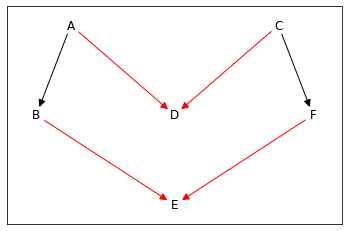

In [9]:
m.reset()
m.learn(make_basic_model=False)

All is well. As expected we get a BN with the desired link. Adding other simple constraints follows the same recipe. Let's disallow the arrow from F to E (found in the `arrow` attribute dictionary) and relearn:

**********
BN has score -24043.920541590247
**********
A<-B -4349.791324894952
B<-E -4227.543778182593
E<- -5468.229676086663
C<-F -3509.5864711079375
F<-B,E -2933.754847081549
D<-A,C -3555.0144442365527
**********
[A|B][B|E][E][C|F][F|B:E][D|C:A]
CPDAG:
Vertices: ['A', 'B', 'E', 'C', 'F', 'D']
A->D
B-A
B-F
E-B
E-F
C->D
F-C



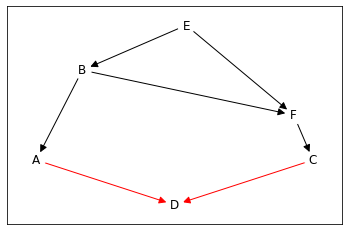

In [10]:
m.arrow['F','E'].ub = 0
m.reset()
m.learn(make_basic_model=False)

It is important to realise that *any* constraint made available by Gurobi can be imposed on the MIP variables Gobnilp has created for learning BNs. For example, we could require that at most 4 of the arrows in the above learned BN are allowed:

[<gurobi.Var A->D (value 1.0)>, <gurobi.Var B->A (value 1.0)>, <gurobi.Var B->F (value 1.0)>, <gurobi.Var C->D (value 1.0)>, <gurobi.Var E->B (value 1.0)>, <gurobi.Var E->F (value 1.0)>, <gurobi.Var F->C (value 1.0)>]
**********
BN has score -24119.316410157637
**********
A<- -5502.137377150637
B<-A -3688.9395212202216
C<- -3501.5105385969146
D<-A,C -3555.0144442365527
E<-B -4854.487880793349
F<-B,C,E -3017.2266481599618
**********
[A][B|A][C][D|C:A][E|B][F|B:E:C]
CPDAG:
Vertices: ['A', 'B', 'C', 'D', 'E', 'F']
A-B
A->D
B-E
B->F
C->D
C->F
E->F



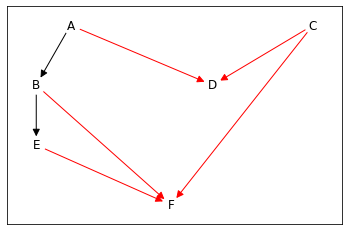

In [17]:
# get all arrows in learned BN. 'X' attribute is value in solution
arrs = [v for v in m.arrow.values() if v.X == 1.0]
print(arrs)
# grab everything from Gurobi
from gurobipy import *
# add constraint that these variables sum to at most 4
m.addConstr(LinExpr([1]*len(arrs),arrs), GRB.LESS_EQUAL, 4)
m.reset()
m.learn(make_basic_model=False)